<a href="https://colab.research.google.com/github/pepborrell/LauzHack2019/blob/master/Copia_de_PredictComment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, Concatenate, TimeDistributed
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.preprocessing.sequence as sequence
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

# Predicting the comment
From an image, we want to predict a comment.

## Loading the data

In [2]:
#url = 'https://pastebin.com/raw/SjMqw5Wx'
# url = 'https://pastebin.com/raw/Kbr3apyg'
# url = 'https://pastebin.com/raw/r2E7KsWP'
url = 'https://pastebin.com/raw/LDU9XZpU'
df = pd.read_csv(url)

df.head()

,id,postid,url,upvotes,top comment
0,0,dpoppg,https://i.redd.it/v91swki75wv31.jpg,125639,['Ah\\ yes\\ the\\ I\\̓\\̉\\̓\\̆\\͗\\̭\\͇\\͙\\...
1,1,dikhsj,https://i.redd.it/osr5o5ox5us31.jpg,105442,"['As\\ an\\ Italian\\,\\ I\\ 100\\%\\ relate',..."
2,2,ds0ttz,https://i.redd.it/p9a9mskj0ww31.jpg,65,"['That\\'s\\ my\\ master\\ plan', 'OP\\ really..."
3,3,dgcuf8,https://i.redd.it/flsim843wvr31.jpg,138513,['What\\'s\\ the\\ difference\\ between\\ 1\\ ...
4,4,dplvla,https://i.redd.it/4j8thq1lyuv31.jpg,35836,"['F', '\\⠀\\⠀\\⢀\\⡤\\⢶\\⣶\\⣶\\⡄\\⠀\\⠀\\⠀\\⠀\\⠀..."


## Extracting information from image
We use a VGG16 model pretrained with ImageNet data. We don't use the last softmax layer, but reuse the other ones.

In [65]:
modelvgg = VGG16(include_top=True,weights='imagenet')

modelvgg.layers.pop()
modelvgg = Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)

modelvgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Extracting data from each image

In [66]:
import urllib
from io import BytesIO
import requests

npix = 224
target_size = (npix,npix,3)

images = {}
for idx, row in df.iterrows():
    print(idx)
    postid = row['postid']
    imageUrl = row['url']
    # postid, imageUrl = row['postid'], row['imageUrl']
    # print(idx)
    try:
        with urllib.request.urlopen(imageUrl) as url:
            img = image.load_img(BytesIO(url.read()), target_size=target_size)
    except:
        continue
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    nimage = preprocess_input(x)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[postid] = y_pred.flatten()
    print('ok')

0
ok
1
ok
2
ok
3
4
ok
5
ok
7
ok
8
ok
9
ok
11
ok
12
ok
13
ok
15
ok
16
ok
17
20
ok
22
ok
23
ok
26
ok
28
ok
30
ok
32
ok
33
ok
34
ok
35
ok
36
ok
37
ok
38
ok
40
ok
42
ok
43
ok
44
ok
45
ok
46
ok
49
ok
50
ok
51
ok
52
ok
54
ok
55
ok
60
ok
65
ok
66
ok
67
ok
69
ok
72
ok
73
ok
75
ok
79
ok
80
ok
82
ok
83
ok
84
ok
86
ok
87
ok
88
ok
89
ok
91
ok
93
ok
94
ok
95
ok
96
ok
98
ok
99
ok
100
ok
101
ok
102
ok
103
ok
104
ok
105
ok
106
ok
107
ok
108
ok
109
ok
111
ok
112
ok
113
ok
115
ok
116
ok
119
ok
120
ok
122
ok
125
ok
126
ok
127
ok
129
ok
130
ok
132
ok
133
ok
134
ok
136
ok
137
ok
140
ok
142
ok
144
ok
146
ok
149
ok
151
ok
153
ok
154
ok
157
ok
159
ok
160
ok
161
ok
163
ok
164
ok
166
ok
167
ok
168
ok
171
ok
173
ok
175
ok
176
ok
178
ok
180
ok
183
ok
184
ok
185
ok
187
ok
188
ok
189
ok
190
ok
192
ok
193
ok
194
ok
195
ok
196
ok
198
ok
199
ok
200
ok
202
ok
203
ok
204
ok
205
ok
206
ok
207
208
ok
210
ok
212
ok
213
ok
214
ok
216
ok
218
ok
220
ok
222
ok
223
ok
224
ok
225
ok
226
ok
227
ok
229
ok
230
ok
231
ok
232
ok
234


In [0]:
import pickle
with open('images.pik', 'wb') as f:
    pickle.dump(images, f)

In [0]:
# Reading a file with the image metadata
import pickle
with open('images.pik', 'rb') as f:
    images = pickle.load(f)

## Text cleaning and preprocessing


In [5]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
st_words = set(stopwords.words('english'))

def cleanWords(text):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    # Convert to lowercase
    text = [word.lower() for word in text]
    # remove punctuation from each token
    text = [word.translate(table) for word in text]
    # remove hanging 's' and 'a'
    text = [word for word in text if len(word)>1 or word in ['i', 'u']]
    # remove tokens with numbers in them
    text = [word for word in text if not word.isnumeric()]
    # remove stopwords
    # text = [word for word in text if not word in st_words]
    # remove forbidden words
    forbidden_words = ['doot']
    text = [word for word in text if word not in forbidden_words]
    return text

def cleanComment(text):
    text = text.split(' ')
    text = cleanWords(text)
    return text

def addStartEndSeq(words):
    return ['startseq'] + words + ['endseq']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
df['clean_comment'] = df.apply(lambda x : cleanComment(x['top comment']), axis=1)

df['clean_comment'] = df.apply(lambda x : addStartEndSeq(x['clean_comment']), axis=1)

max_comment_length = max(len(x) for x in df['clean_comment'])
max_comment_length = 30

df_copy = df
df = df[df['clean_comment'].apply(lambda x : len(x) >= 3)]
df = df[df['clean_comment'].apply(lambda x : len(x) <= max_comment_length)]

all_text = []
for text in df['clean_comment']:
    all_text += text

from collections import Counter
counter = Counter(all_text)
word_freq = list(counter.items())
word_freq.sort(key = (lambda x : -x[1]))
word_freq = ['PAD'] + word_freq

# To check where are word frequencies change
# for idx, elem in enumerate(word_freq):
#     if elem[1] == 2:
#         print(idx)
#         break

(array([ 0., 12., 40., 45., 56., 39., 48., 32., 23.,  0.]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ]),
 <a list of 10 Patch objects>)

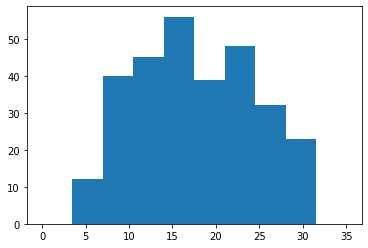

In [0]:
import matplotlib.pyplot as plt
sizes = [len(x) for x in df['clean_comment']]
plt.hist(sizes, range=(0,35))

In [0]:
print(word_freq)

['PAD', ('the', 661), ('startseq', 480), ('endseq', 480), ('i', 391), ('to', 346), ('you', 315), ('and', 310), ('that', 271), ('is', 270), ('of', 254), ('it', 241), ('in', 147), ('not', 136), ('for', 136), ('this', 127), ('but', 120), ('just', 117), ('are', 114), ('my', 113), ('on', 111), ('with', 106), ('have', 104), ('they', 102), ('its', 99), ('was', 99), ('like', 94), ('so', 92), ('what', 90), ('if', 90), ('no', 90), ('me', 80), ('your', 79), ('be', 72), ('can', 71), ('we', 68), ('do', 68), ('or', 67), ('im', 61), ('one', 60), ('he', 60), ('all', 60), ('people', 59), ('about', 57), ('as', 56), ('more', 54), ('at', 53), ('when', 52), ('because', 51), ('dont', 50), ('from', 48), ('only', 47), ('know', 47), ('think', 47), ('would', 45), ('who', 44), ('how', 44), ('up', 42), ('then', 41), ('ok', 40), ('an', 39), ('get', 39), ('say', 38), ('even', 38), ('thats', 37), ('good', 37), ('out', 37), ('here', 37), ('were', 37), ('will', 37), ('now', 35), ('than', 34), ('there', 33), ('their', 

# Creating the other dictionary
using the Flickr 8K database

In [18]:
!wget https://raw.githubusercontent.com/text-machine-lab/MUTT/master/data/flickr/Flickr8k.token.txt
#Finding the captions for each image.
file = open('Flickr8k.token.txt','r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])
# flickr_df = pd.read_csv('https://raw.githubusercontent.com/text-machine-lab/MUTT/master/data/flickr/Flickr8k.token.txt', sep='\t', header=None)

# flickr_df.head()

--2019-11-17 07:47:42--  https://raw.githubusercontent.com/text-machine-lab/MUTT/master/data/flickr/Flickr8k.token.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3395237 (3.2M) [text/plain]
Saving to: ‘Flickr8k.token.txt.10’

Flickr8k.token.txt. 100%[===================>]   3.24M  --.-KB/s    in 0.1s    

2019-11-17 07:47:42 (32.0 MB/s) - ‘Flickr8k.token.txt.10’ saved [3395237/3395237]

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename  ...                                            caption
0  1000268201_693b08cb0e.jpg  ...  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg  ...              a girl going into a wooden building .
2  1000268201_693b08cb0e.

In [19]:

# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


In [21]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)


def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


## Top 50 words in the dataset

Vocabulary Size: 8763


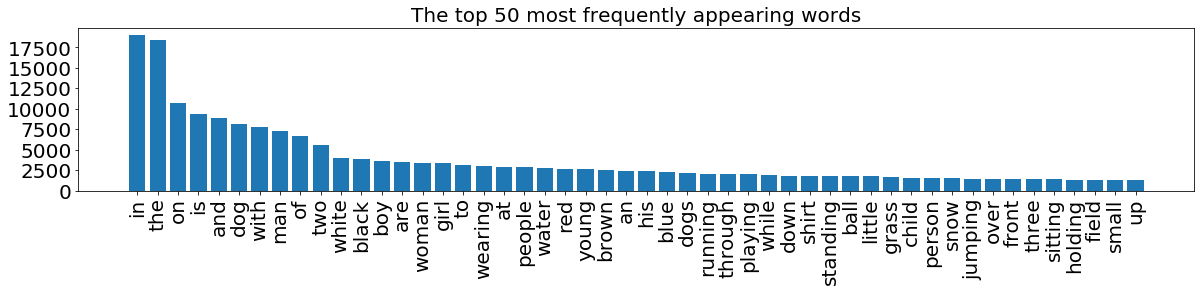

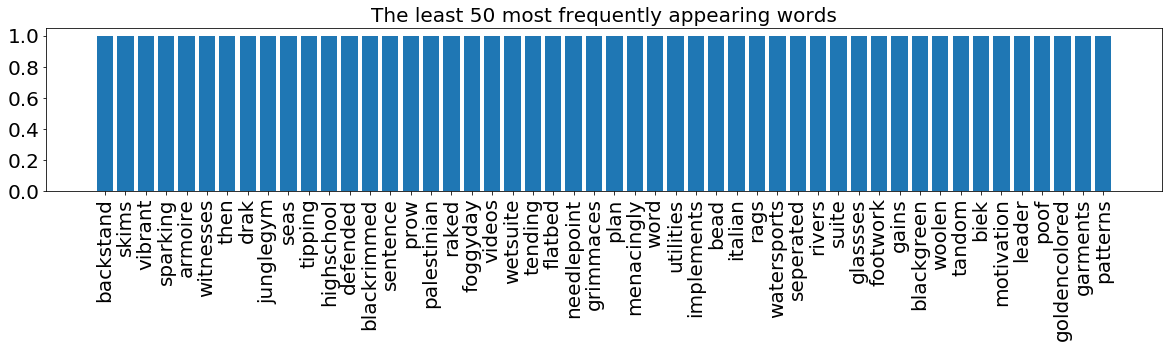

In [23]:
import matplotlib.pyplot as plt


topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [0]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [0]:
keepindex = []
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    # if fnm in images.keys():
    keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values

In [32]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 523, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [0]:
word_to_idx = tokenizer.word_index
idx_to_word = tokenizer.index_word

In [0]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [35]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


## Creating the word encoding
We assign a number to each word, and encode them using these numbers. In this way, the sentences will now be of the form [1,4,2,6,2,...] (padded to match the needed size)

In [0]:
vocab_size = 1024

word_to_idx = {}
idx_to_word = {}
for idx, elem in enumerate(word_freq[:vocab_size]):
    word_to_idx[elem[0]] = idx
    idx_to_word[idx] = elem[0]

In [48]:
def encodeComment(words):
    # encoding = np.zeros(max_comment_length, dtype=int)
    encoding = [word_to_idx[word] for word in words if word in word_to_idx]
    encoding = np.asarray(encoding)
    # encoding = sequence.pad_sequences([encoding], maxlen=max_comment_length, padding='post')
    encoding = np.reshape(encoding, (len(encoding),))
    # encoding = to_categorical(encoding,num_classes = vocab_size)
    return encoding

df['encoded_comment'] = df.apply(lambda x : encodeComment(x['clean_comment']), axis=1)
df.head()

,id,postid,url,upvotes,top comment,clean_comment,encoded_comment
0,0,dpoppg,https://i.redd.it/v91swki75wv31.jpg,125639,['Ah\\ yes\\ the\\ I\\̓\\̉\\̓\\̆\\͗\\̭\\͇\\͙\\...,"[startseq, ah, yes, the, i̭͇͙̘̤̗̹̣̞̙̝͖̗̮̮̓̉̓̆͗...","[1, 4, 850, 2]"
1,1,dikhsj,https://i.redd.it/osr5o5ox5us31.jpg,105442,"['As\\ an\\ Italian\\,\\ I\\ 100\\%\\ relate',...","[startseq, as, an, italian, i, relate, thats, ...","[1, 67, 24, 3330, 1685, 1234, 1369, 2049, 2]"
2,2,ds0ttz,https://i.redd.it/p9a9mskj0ww31.jpg,65,"['That\\'s\\ my\\ master\\ plan', 'OP\\ really...","[startseq, thats, my, master, plan, op, really...","[1, 3327, 81, 4, 1317, 4, 2]"
3,3,dgcuf8,https://i.redd.it/flsim843wvr31.jpg,138513,['What\\'s\\ the\\ difference\\ between\\ 1\\ ...,"[startseq, whats, the, difference, between, an...","[1, 4, 327, 5, 1193, 1685, 1799, 1585, 7, 1209..."
4,4,dplvla,https://i.redd.it/4j8thq1lyuv31.jpg,35836,"['F', '\\⠀\\⠀\\⢀\\⡤\\⢶\\⣶\\⣶\\⡄\\⠀\\⠀\\⠀\\⠀\\⠀...","[startseq, ⠀⠀⢀⡤⢶⣶⣶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀, nn⠀⠀⢀⣠⣤⣤⣤⣿⣧⣀⣀⣀...","[1, 2]"


## Preparing the inputs
Now that everything is well filtered we can prepare the input for the neural network

In [0]:
def splitData(data, data_size):
    train_division = int(0.6*data_size)
    test_division = int(0.8*data_size)

    data_train = data[0:train_division]
    data_test = data[train_division+1:test_division]
    data_val = data[test_division+1:]
    return data_train, data_test, data_val

df_size = df.shape[0]  # gives number of row count
[df_train, df_test, df_val] = splitData(df, df_size)

In [0]:
def preprocessing(df, images):
    Xtext, Ximage, ytext = [],[],[]
    for idx, row in df.iterrows():
        if row['postid'] in images:
            text = row['encoded_comment']
            for i in range(1, len(text)):
                in_text, out_text = text[:i], text[i]
                in_text = sequence.pad_sequences([in_text],maxlen=max_comment_length, padding='post').flatten()
                out_text = to_categorical(out_text,num_classes = vocab_size)
                                        
                Xtext.append(in_text)
                Ximage.append(images[row['postid']])
                ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)

    return (Xtext,Ximage,ytext)

## Defining the model
We will use the Keras functional API. We will define a model that recieves the comments and passes them through Embedding and LSTM layers, and also recieves the information from the images and channels it all through some dense layers.

In [0]:
# hyperparameters
embedding_dim = 256
vgg_output_size = 4096


In [0]:
# image feature extractor model
inputs1 = Input(shape=(vgg_output_size,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_comment_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se3 = Dropout(0.5)(se3)
se3, state_h, state_c = LSTM(256, return_state=True)(se3)
encoder_states = [state_h, state_c]


# decoder (feed forward) model
decoder1 = Add()([fe2, se3])
# decoder1 = Embedding(vocab_size, embedding_dim)(decoder1)
# decoder1 = LSTM(256)(decoder1)
# decoder1 = Concatenate()([fe2, se3])
# decoder1 = se3
decoder2 = Dense(256, activation='relu')(decoder1)
decoder2 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
[xtext_train, ximage_train, ytrain] = preprocessing(df_train, images)
[xtext_test, ximage_test, ytest] = preprocessing(df_test, images)
[xtext_val, ximage_val, yval] = preprocessing(df_val, images)

In [0]:
model.fit([ximage_train, xtext_train], ytrain, epochs=1, batch_size=128)

Train on 8239 samples
8239/8239 [==============================] - 85s 10ms/sample - loss: 6.0701


In [0]:
model.save('model.h5')

## Predicting photo captions with the model
A so-called 'greedy-search' algorithm feeds the picture and a start sequence to the network. It then takes the output word and feeds it along with the picture to the net again. This goes on until the word limit is achieved or an end sequence is received.

In [0]:
import time

def inverseFreq(word_freq):
    output = []
    for elem in word_freq:
        if elem != 'PAD':
            output.append(1/elem[1])
        else:
            output.append(0)
    return np.array(output)

def greedySearch(photo):
    np.random.seed(int(time.time()))
    # in_text = idx_to_word[np.random.randint(1, 100, 1)[0]]
    in_text = 'startseq'
    comment_length = 25
    # for i in range(max_comment_length):
    for i in range(comment_length):
        seq = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        seq = sequence.pad_sequences([seq], maxlen=max_comment_length, padding='post')
        yhat = model.predict([photo, seq])
        yhat[0][word_to_idx['endseq']] -= 0.05*max(20-i, 0)
        # yhat[0][word_to_idx[in_text.split()[-1]]] -= 1
        # yhat = yhat*inverseFreq(word_freq[:vocab_size])*1.3

        # for idx, word in enumerate(in_text.split(' ')):
        #     yhat[0][word_to_idx[word]] -= max(0.3 - idx*0.01, 0)
        
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    # final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
output = greedySearch(np.array([ximage_test[100]]))
print(output)

startseq no the its dont to have is i from endseq


In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 394)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 394, 256)     262144      input_16[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 394, 256)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 4096)]       0                                            
____________________________________________________________________________________________

## Another model

In [130]:
import tensorflow.keras as keras

model = keras.models.load_model('Image_Caption_Generator.h5')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 256)      0           CaptionFeature[0][0]             
____________________________________________________________________________________________

In [131]:
for layer in model.layers[:-1]:
    layer.trainable = False
    print(layer, layer.trainable)

model.compile(optimizer='adam', loss='categorical_crossentropy')

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efc6b397c50> False
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7efc6b397550> False
<tensorflow.python.keras.layers.recurrent.LSTM object at 0x7efc6b397b38> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7efc6b397d30> False
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efc6b3db5c0> False
<tensorflow.python.keras.layers.recurrent.LSTM object at 0x7efc6b396f98> False
<tensorflow.python.keras.layers.core.Dense object at 0x7efc6b3db198> False
<tensorflow.python.keras.layers.merge.Add object at 0x7efc6b3db2b0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7efc6b3dbe80> False


In [132]:
model.fit([ximage_train, xtext_train], ytrain, epochs=50, batch_size=32)

Train on 1518 samples
Epoch 1/50
1518/1518 [==============================] - 6s 4ms/sample - loss: 10.0472
Epoch 2/50
1518/1518 [==============================] - 2s 1ms/sample - loss: 9.4450
Epoch 3/50
1518/1518 [==============================] - 2s 1ms/sample - loss: 8.9297
Epoch 4/50
1518/1518 [==============================] - 2s 1ms/sample - loss: 8.4808
Epoch 5/50
1518/1518 [==============================] - 2s 2ms/sample - loss: 8.0730
Epoch 6/50
1518/1518 [==============================] - 2s 2ms/sample - loss: 7.7069
Epoch 7/50
1518/1518 [==============================] - 2s 2ms/sample - loss: 7.3692
Epoch 8/50
1518/1518 [==============================] - 2s 2ms/sample - loss: 7.0728
Epoch 9/50
1518/1518 [==============================] - 2s 1ms/sample - loss: 6.7970
Epoch 10/50
1518/1518 [==============================] - 2s 1ms/sample - loss: 6.5607
Epoch 11/50
1518/1518 [==============================] - 2s 2ms/sample - loss: 6.3265
Epoch 12/50
1518/1518 [=================

In [139]:
# output = greedySearch(np.array([ximage_test[93]]))
idx = 134
output = greedySearch(np.array([images[df['postid'][idx]]]))
print(output)
print(df['url'][idx])



startseq have the new our the how in new but where make language make in the table can ball endseq
https://i.redd.it/o0sqcj0o2tw31.jpg
